# Formalização Teórica do DODAG

### Grafo inicial

Seja $V$ um conjunto de pontos em $\mathbb{R}^n$ ($n$ deve ser 2 ou 3 dependendo da aplicação). Definimos $\phi\in\mathbb{R}$ o raio de alcance, supondo que cada ponto possui o mesmo raio de alcance. Agora definimos o grafo $G=(V,E)$ onde $E$ é definido da seguinte forma:
$$
E:=\{(u,v)\in V\times V : d(u,v)<\phi\}
$$
sendo $d$ a distância euclidiana.

**Importante** 

A partir deste ponto, consideraremos que $G=(V,E)$ é um grafo conexo, e escolhemos um vértice $r\in V$ para ser a raiz. 

### Vizinhança
Defina $N_G:V\rightarrow 2^V$ a função que indica quais são os vizinhos de um vértice $v\in V$. 
$$
N_G(v):=\{u_1,u_2,...,u_k\}\Leftrightarrow \exists(u_i,v)\in E, \forall i\in\{1,2,...,k\}.
$$
Para simplificar a notação, denotaremos $N_G(v)$ como $Nv$, o conjunto de vizinhos de $v$ no grafo $G$.


### Função Custo
Denotamos $C:E\rightarrow \mathbb{R}^+$ a função custo ou peso da aresta. Esta função pode ser definida de várias formas, no caso mais simples *hop count* esta é constante igual a 1. Além disso, para qualquer $(u,v)\in E$, $C(u,v)>0$, esta restrição é importante para garantir que o digrafo seja aciclico.

### Função Objetivo
A função objetivo $OF:V\rightarrow\mathbb{R}$ é definida por:

$$
OF(v):=\begin{cases}
0, &\text{se }v=r,\\
\min_{u \in Nv} \big( C(v, u) + OF(u) \big), &\text{se }v\neq r.
\end{cases}
$$

Assim $OF(v)$ é o custo acumulado do nó $v$ até a raiz $r$.

Em geral precisamos definir $OF$ iterativamente, isso é feito da seguinte forma:
1. Inicialização:
$$
OF^{(0)}(v) =
\begin{cases}
0, & \text{se } v = r, \\
+\infty, & \text{caso contrário}.
\end{cases}
$$

2. Iteração:
$$
OF^{(t+1)}(v) = \min_{u \in N(v)} \big\{ C(v, u) + OF^{(t)}(u) \big\}, \quad \forall v \in V.
$$

3. Convergência:

    O algoritmo para quando $OF^{(t+1)}(v) = OF^{(t)}(v)$, $\forall v \in V$.

## Construção do DODAG

Definimos o digrafo DODAG como $D = (V, E_D)$, onde $E_D$ é construído com base na função objetivo $OF$:
$$
E_D := \big\{(u, v) \in E : v = \arg \min_{w \in N_G(u)} \big( C(u, w) + OF(w) \big) \big\}.
$$

#### Propriedades do DODAG:
1. **Aciclicidade:** Garante-se que $D$ é um digrafo acíclico devido à propriedade $C(u, v) > 0$, que impede ciclos positivos no grafo.
2. **Orientação ao Destino:** Todos os caminhos convergem para o vértice raiz $r$.

#### Algoritmo de Construção:
1. Inicialização:

   $D = (V, \emptyset)$.

2. Construção Iterativa:

   Para cada $v \in V \setminus \{r\}$, identifique $u$ tal que:
   $$
   u = \arg \min_{w \in N_G(v)} \big( C(v, w) + OF(w) \big).
   $$
   Adicione $(u, v)$ a $E_D$.

3. Finalização:

   Retorne $D = (V, E_D)$.

#### Validação do DODAG:
   A conectividade do grafo inicial $G$ e a definição de $C(u, v) > 0$ garantem que:
   - Todos os vértices $v \in V$ têm um caminho até a raiz $r$.
   - Não há ciclos no grafo resultante.


# Implementação

## Montagem do Grafo Inicial

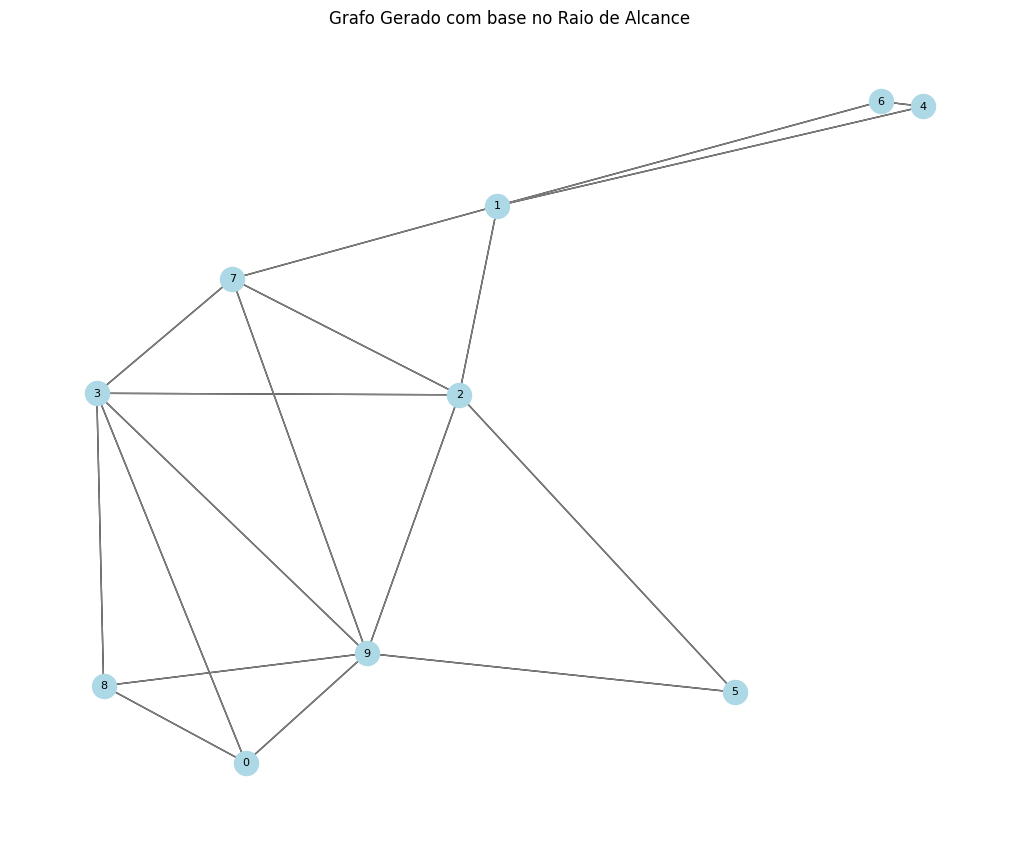

In [1]:
# Importar as bibliotecas necessárias
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Configuração inicial: conjunto de pontos (nós) e raio de alcance
np.random.seed(11)
num_nodes = 10
radius = 50
area_size = 100

# Gerar posições aleatórias para os nós no plano 2D
positions = {i: (np.random.uniform(0, area_size), np.random.uniform(0, area_size)) for i in range(num_nodes)}

# Criar o grafo baseado no alcance
G = nx.Graph()
G.add_nodes_from(positions.keys())
for u in positions:
    for v in positions:
        if u != v and np.linalg.norm(np.array(positions[u]) - np.array(positions[v])) < radius:
            G.add_edge(u, v)

# Visualizar o grafo
plt.figure(figsize=(10, 8))
pos = positions
nx.draw(G, pos, with_labels=True, node_size=300, node_color="lightblue", font_size=8)
nx.draw_networkx_edges(G, pos, edge_color="gray")
plt.title("Grafo Gerado com base no Raio de Alcance")
plt.show()

## Função Objetivo 

In [4]:
# Escolher um nó raiz arbitrariamente
root = 0

# Definir a função custo (constante para hop count)
def cost(u, v):
    return 1  # Hop count (constante)

# Inicializar a função objetivo (OF)
OF = {node: float('inf') for node in G.nodes}
OF[root] = 0  # O custo da raiz até ela mesma é zero

# Função para calcular OF iterativamente
def compute_of(G, root, cost):
    OF_iter = OF.copy()
    for u in G.nodes:
        if u != root:
            OF_iter[u] = min(
                [cost(u, v) + OF[v] for v in G.neighbors(u)] + [OF_iter[u]]
            )        
    return OF_iter

# Calcular o OF iterativa 
while True:
    prev_OF = np.array(list(OF.values())) 
    OF = compute_of(G, root, cost)
    if np.array_equal(list(OF.values()), prev_OF):
      break

# Exibir os resultados
print("Função Objetivo (OF) para cada nó:")
for node, value in OF.items():
    print(f"OF({node}) = {value}")

Função Objetivo (OF) para cada nó:
OF(0) = 0
OF(1) = 3
OF(2) = 2
OF(3) = 1
OF(4) = 4
OF(5) = 2
OF(6) = 4
OF(7) = 2
OF(8) = 1
OF(9) = 1


## DODAG

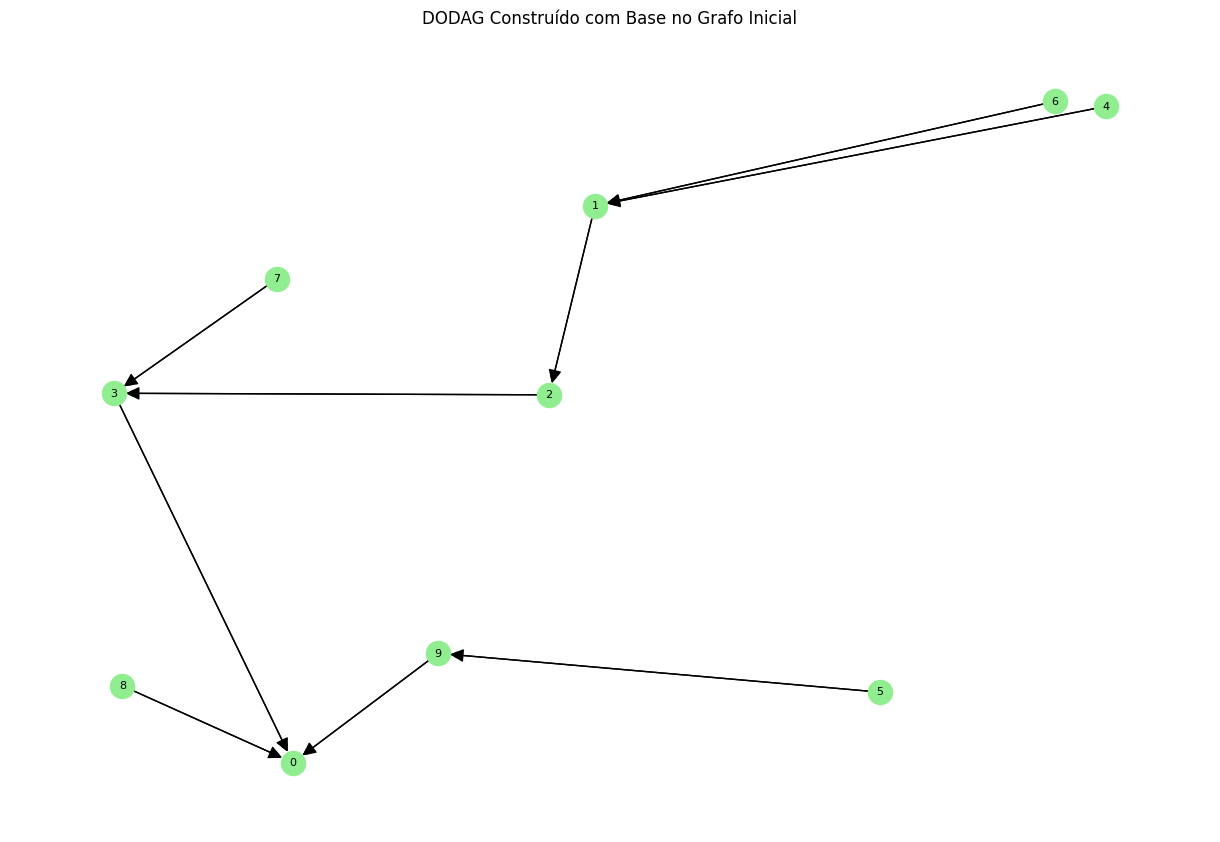

In [3]:
# Construir o DODAG
DODAG = nx.DiGraph()
DODAG.add_nodes_from(G.nodes)

def argmin_neighbor(v):
    """Encontra o nó vizinho que minimiza o custo acumulado"""
    min_neighbor = None
    min_cost = float('inf')
    for u in G.neighbors(v):
        current_cost = cost(v, u) + OF[u]
        if current_cost < min_cost:
            min_cost = current_cost
            min_neighbor = u
    return min_neighbor

for v in G.nodes:
    if v != root:
        # Encontrar o nó vizinho que minimiza o custo acumulado
        min_neighbor = argmin_neighbor(v)
        if min_neighbor is not None:
            DODAG.add_edge(v, min_neighbor)

# Visualizar o DODAG
plt.figure(figsize=(12, 8))
pos = positions
nx.draw(DODAG, pos, with_labels=True, node_size=300, node_color="lightgreen", font_size=8, arrows=True)
nx.draw_networkx_edges(DODAG, pos, edge_color="black", arrowsize=20)
plt.title("DODAG Construído com Base no Grafo Inicial")
plt.show()

# Exemplo Extra
## DODAG em Grafo Completo com Custos Aleatórios

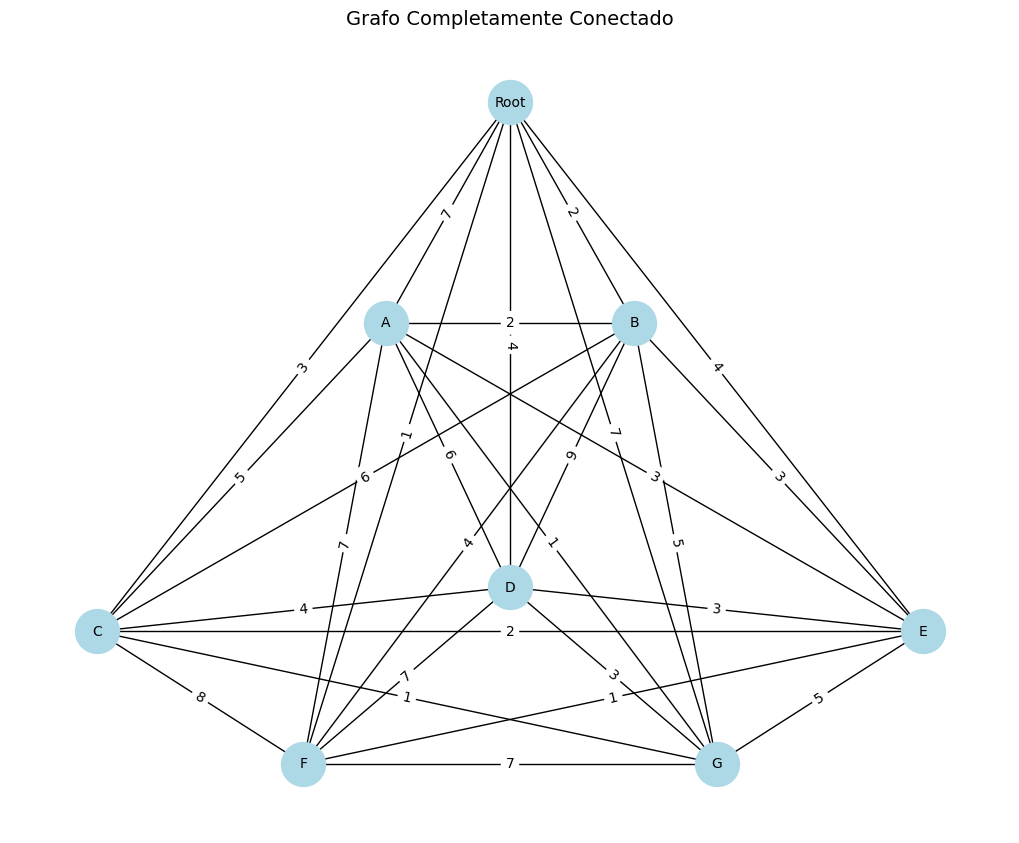

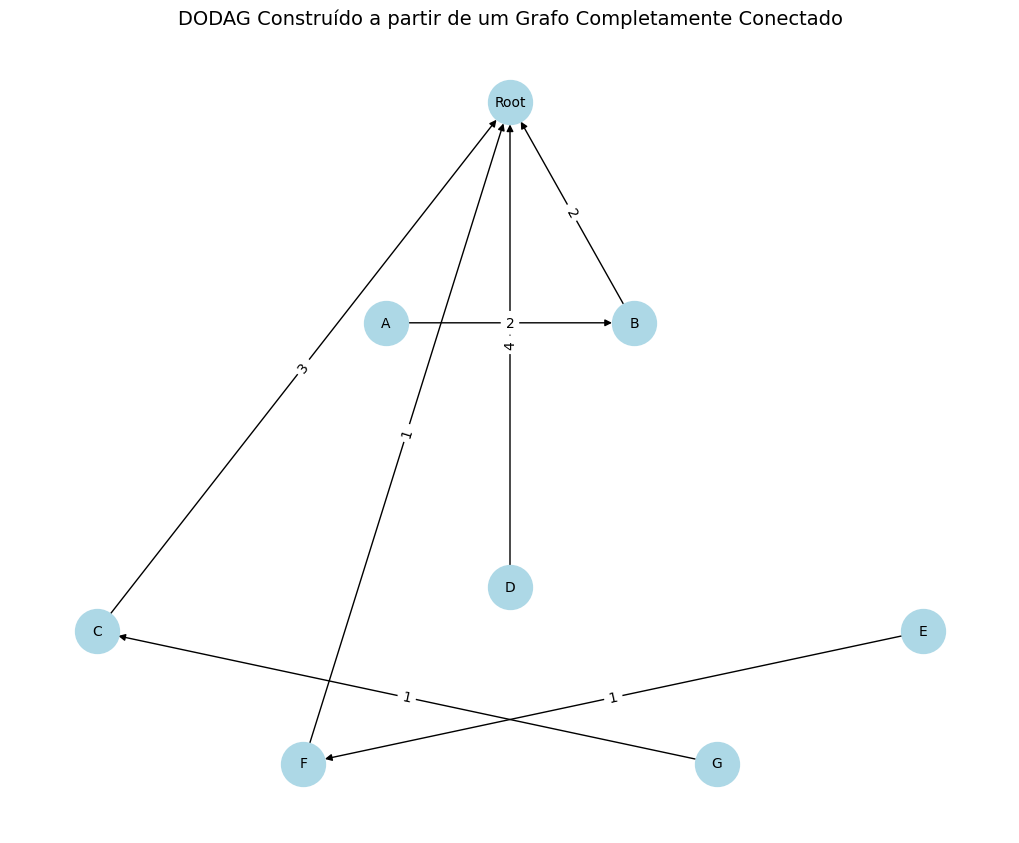

{'Root': 0, 'A': 4, 'B': 2, 'C': 3, 'D': 4, 'E': 2, 'F': 1, 'G': 4}

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Definir os nós e suas posições
nodes = {
    "Root": (0, 0),
    "A": (-0.6, -1),
    "B": (0.6, -1),
    "C": (-2, -2.4),
    "D": (0, -2.2),
    "E": (2, -2.4),
    "F": (-1, -3),
    "G": (1, -3),
}

# Criar um grafo completamente conectado
G_full = nx.complete_graph(len(nodes), create_using=nx.Graph())

# Mapear nós ao grafo completo
node_names = list(nodes.keys())
mapping = {i: name for i, name in enumerate(node_names)}
G_full = nx.relabel_nodes(G_full, mapping)

# Atribuir métricas (custos aleatórios para simulação)
np.random.seed(12)
for u, v in G_full.edges:
    if u != v:  # Excluindo laços
        G_full[u][v]['cost'] = np.random.randint(1, 10)

plt.figure(figsize=(10, 8))
nx.draw(G_full, nodes, with_labels=True, node_size=1000, node_color="lightblue", font_size=10)
labels = nx.get_edge_attributes(G_full, 'cost')
nx.draw_networkx_edge_labels(G_full, nodes, edge_labels=labels)
plt.title("Grafo Completamente Conectado", fontsize=14)
plt.show()

# Construir o DODAG usando a métrica mínima acumulada
OF_dodag = {node: float('inf') for node in G_full.nodes}
OF_dodag["Root"] = 0

def compute_of(G, root, cost):
    OF_iter = OF_dodag.copy()
    for u in G.nodes:
        if u != root:
            OF_iter[u] = min(
                [cost(u, v) + OF_dodag[v] for v in G.neighbors(u)] + [OF_iter[u]]
            )        
    return OF_iter

# Calcular o OF iterativa 
while True:
    prev_OF = np.array(list(OF_dodag.values())) 
    OF_dodag = compute_of(G_full, 'Root', lambda u,v: G_full[u][v]['cost'])
    if np.array_equal(list(OF_dodag.values()), prev_OF):
      break

def argmin_neighbor(G, v, cost, OF):
    """Encontra o nó vizinho que minimiza o custo acumulado"""
    min_neighbor = None
    min_cost = float('inf')
    for u in G.neighbors(v):
        current_cost = cost(v, u) + OF[u]
        if current_cost < min_cost:
            min_cost = current_cost
            min_neighbor = u
    return min_neighbor

DODAG = nx.DiGraph()
DODAG.add_nodes_from(G_full.nodes)

for v in G_full.nodes:
    if v != 'Root':
        # Encontrar o nó vizinho que minimiza o custo acumulado
        min_neighbor = argmin_neighbor(G_full, v, lambda u,v: G_full[u][v]['cost'], OF_dodag)
        if min_neighbor is not None:
            DODAG.add_edge(v, min_neighbor, cost=G_full[v][min_neighbor]['cost'])

# Visualizar o DODAG final
plt.figure(figsize=(10, 8))
nx.draw(DODAG, nodes, with_labels=True, node_size=1000, node_color="lightblue", font_size=10)
labels = nx.get_edge_attributes(DODAG, 'cost')
nx.draw_networkx_edge_labels(DODAG, nodes, edge_labels=labels)
plt.title("DODAG Construído a partir de um Grafo Completamente Conectado", fontsize=14)
plt.show()

# Mostrar custos acumulados finais
OF_dodag
